# Analisis de Mapas
### Jeff McMahon y Renée Hložek. Traducción por Cristian Vargas

Analizaremos los mapas de varias maneras. Primero, en esta parte, usaremos una técnica de Monte Carlo para recuperar el espectro de potencia, con ejercicios en el camino. En la quinta parte, usaremos un filtro adaptado para separar la señal SZ y las fuentes puntuales, y trabajaremos apilando mapas usando el catálogo de cúmulos de galaxias simulado, esto es similar a usar un catalog proveniente de un estudio externo, por ejemplo un catálogo óptico o de rayos-x.

## Espectro de potencia
 
En esta sección calculamos el espectro de potencia de un mapa CMB. Trabajaremos en la aproximación de cielo plano descrita en la primera sección, donde generamos el mapa CMB simulado.

In [1]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

%matplotlib inline
import constantes as cs # modulo de constantes

from cmb_modulos import * # modulo de funciones

N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_ancho =cs.X_ancho
Y_ancho = cs.Y_ancho
tamaño_haz_fwhm = cs.tamaño_haz_fwhm

tamaño_pix = cs.tamaño_pix

Numero_de_Fuentes  = cs.Numero_de_Fuentes
Amplitud_de_Fuentes = cs.Amplitud_de_Fuentes
Numero_de_Fuentes_EX = cs.Numero_de_Fuentes_EX
Amplitud_de_Fuentes_EX = cs.Amplitud_de_Fuentes_EX

Numero_de_Cumulos_SZ  = cs.Numero_de_Cumulos_SZ
Amplitud_promedio_de_cumulos_SZ = cs.Amplitud_promedio_de_cumulos_SZ
SZ_beta = cs.SZ_beta
SZ_Theta_central = cs.SZ_Theta_central

nivel_de_ruido_blanco = cs.nivel_de_ruido_blanco
nivel_de_ruido_atmosferico = cs.nivel_de_ruido_atmosferico
nivel_de_ruido_1sobref = cs.nivel_de_ruido_1sobref

## Recalculando los resultados de las etapas anteriores

promedio del mapa: 4.086383144170571 , media cuadrática (rms) del mapa: 104.23737382548644


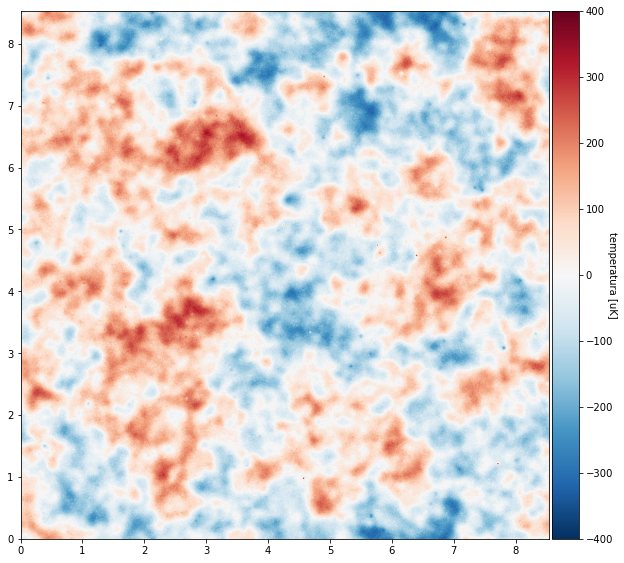

In [2]:
## Hacer un mapa CMB
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = crear_mapa_CMB_T(N,tamaño_pix,ell,DlTT)

## hacer un mapa de fuentes puntuales
MapaFP = componente_Poisson(N,tamaño_pix,Numero_de_Fuentes,Amplitud_de_Fuentes) 
MapaFP += componente_Exponencial(N,tamaño_pix,Numero_de_Fuentes_EX,Amplitud_de_Fuentes_EX)

## hacer un mapa SZ
MapaSZ,catSZ = componente_SZ(N,tamaño_pix,Numero_de_Cumulos_SZ,Amplitud_promedio_de_cumulos_SZ,
                                     SZ_beta,SZ_Theta_central,False)

## agregar todos juntos para obtener el mapa del cielo en una sola frecuencia
mapa_total = CMB_T + MapaFP + MapaSZ

## incorporando el impacto de instrumento
    ## haz
CMB_T_convolucionado = mapa_convolucionado_con_haz_gaussiano(N,tamaño_pix,tamaño_haz_fwhm,mapa_total)
    ## ruido
Ruido = hacer_mapa_de_ruido(N,tamaño_pix,nivel_de_ruido_blanco,nivel_de_ruido_atmosferico,nivel_de_ruido_1sobref)

mapa_total_mas_ruido = CMB_T_convolucionado + Ruido

## Grafica el resultado
p = Graficar_Mapa_CMB(mapa_total_mas_ruido,c_min,c_max,X_ancho,Y_ancho)

### Apodizar el mapa para eliminar los efectos de borde

Antes de tomar una transformada de Fourier 2d (que es lo que se debe hacer para calcular un espectro de potencia) debemos apodizar los mapas para eliminar los efectos de los bordes. Los efectos de borde se producen porque la transformada de Fourier trata al arreglo cuadrado como si tuviera límites periódicos. Por lo tanto, si tomamos la transformada de Fourier de un mapa bidimensional y los valores en el lado izquierdo y derecho (y también en la parte superior e inferior) del mapa no coinciden, terminamos generando señales espurias. En este ejemplo, usamos una ventana de coseno para reducir suavemente la señal a cero a medida que nos acercamos a los bordes del mapa. Hay muchas opciones de ventanas que intercambian pérdida de sensibilidad, acoplamiento de modos adyacentes y ringing.

promedio del mapa: 4.004681761099453 , media cuadrática (rms) del mapa: 51.34959754558915


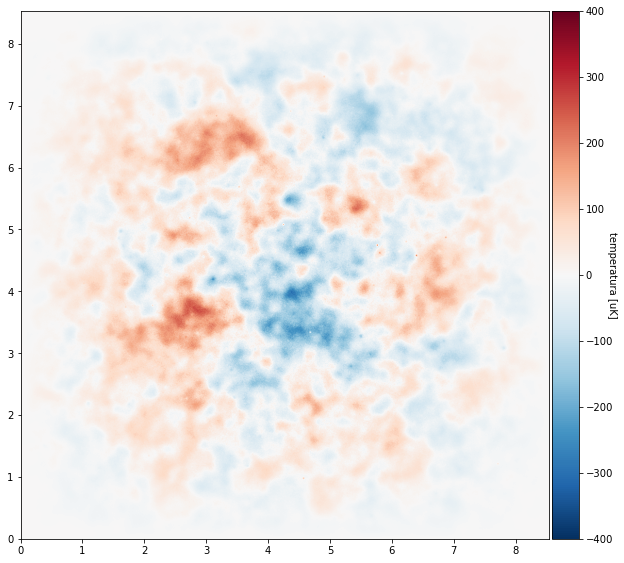

In [3]:
def ventana_coseno(N):
    "crea una ventana de coseno para apodizar y evitar efectos de bordes en la transformada de Fourier 2d"
    # hace un sistema de coordenadas 2d
    N=int(N) 
    unos = np.ones(N)
    indices = (np.arange(N)+.5 - N/2.)/N *np.pi ## por ejemplo, va de -pi/2 a pi/2
    X = np.outer(unos,indices)
    Y = np.transpose(X)
  
    # hace un mapa de ventana
    mapa_ventana = np.cos(X) * np.cos(Y)
   
    # retorna el mapa de ventana
    return(mapa_ventana)
  ###############################
    
ventana = (ventana_coseno(N))
    
mapa_apodizado = ventana * mapa_total_mas_ruido

p=Graficar_Mapa_CMB(mapa_apodizado,c_min,c_max,X_ancho,Y_ancho)

Esto muestra nuestro mapa simulado con una ventana de coseno aplicada para eliminar los efectos de borde. Es claro que en este mapa estamos suprimiendo la señal.

<font color='red'>EJERCICIO: </font> Hay una gran cantidad de ventanas bien estudiadas con varias combinaciones de propiedades. Algunas minimizan el acoplamiento de modos, otras minimizan la pérdida de señal, mientras que otras maximizan alguna combinación de los dos. Encuentra el artículo de wikipedia sobre las ventanas de transformadas de Fourier, elije una que te guste e impleméntela como una opción. Compara el impacto de la nueva ventana en comparación con la ventana de coseno simple en el mapa.

In [4]:
## tu codigo y graficos van aqui

Tus comentarios van aqui.

### Espectro de potencia ingenuo

Aquí calculamos un espectro de potencia ingenuo y lo comparamos con el espectro de potencia de entrada para nuestras simulaciones. El espectro de potencia se calcula: 

(1) aplicando una transformada de Fourier 2d 

(2) tomando el valor absoluto al cuadrado de este mapa en el espacio de Fourier ($k_x$ y $k_y$)

(3) promediando la señal en contenedores de anillos de $k = (k_x^2 + k_y^2)^{1/2}$. Estos contenedores se convierten en contenedores en $\ell$ con la escala: $\ell = 2 \pi k$ según la aproximación de cielo plano.


NOTA: el paso 3 (promedio en contenedores radiales) es cómo convertimos nuestro mapa de Fourier 2d en un espectro de potencia 1d.


Nuestro código de espectro toma dos mapas como entradas para permitir espectros cruzados cuando lleguemos a la polarización en la Parte Siete.

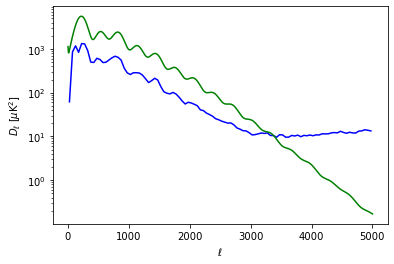

In [5]:
#### parámetros para configurar el espectro
delta_ell = 50.
ell_max = 5000.

if max(ell)< ell_max: 
        print("ADVERTENCIA: las curvas teoricas terminan antes de ell_max (no están definidas más allá)")
        
def calcular_espectro_2d(Mapa1,Mapa2,delta_ell,ell_max,tamaño_pix,N):
    """calcula el espectro de potencia de un mapa 2d mediante la transformada de Fourier FFT, 
       elevando al cuadrado y promediando azimutalmente"""
    N=int(N)
    # hacer un sistema de coordenadas ell 2d
    unos = np.ones(N)
    indices  = (np.arange(N)+.5 - N/2.) /(N-1.)
    kX = np.outer(unos,indices) / (tamaño_pix/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_factor_escala = 2. * np.pi 
    ell2d = K * ell_factor_escala
    
    # hacer un arreglo para guardar los resultados del espectro de potencia
    N_contenedores = int(ell_max/delta_ell)
    ell_arreglo = np.arange(N_contenedores)
    CL_arreglo = np.zeros(N_contenedores)
    
    # obtener la transformada de Fourier 2d del mapa
    Mapa1F = np.fft.ifft2(np.fft.fftshift(Mapa1))
    Mapa2F = np.fft.ifft2(np.fft.fftshift(Mapa2))
    MapaEP = np.fft.fftshift(np.real(np.conj(Mapa1F) * Mapa2F))
    # rellenar el espectro
    i = 0
    while (i < N_contenedores):
        ell_arreglo[i] = (i + 0.5) * delta_ell
        indices_en_contenedor = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_arreglo[i] = np.mean(MapaEP[indices_en_contenedor])
        #print i, ell_arreglo[i], indices_en_contenedor, CL_arreglo[i]
        i = i + 1
 
    # retorna el espectro de potencia y los contenedores de ell
    return(ell_arreglo,CL_arreglo*np.sqrt(tamaño_pix /60.* np.pi/180.)*2.)

## hacer un espectro de potencia
binned_ell, binned_spectrum = calcular_espectro_2d(mapa_apodizado,mapa_apodizado,delta_ell,ell_max,tamaño_pix,N)
#print binned_ell
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi,color="blue")
plt.semilogy(ell,DlTT, color="green")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

Este gráfico muestra el espectro de potencia CMB de entrada (verde) y el espectro de potencia ingenuo que estimamos a partir de nuestro mapa CMB (azul). El espectro ingenuo no coincide con la entrada debido a una combinación de: ruido instrumental, SZ y señales de fuente puntual; supresión del haz y la apodización.

<font color='red'>EJERCICIO: </font> Comenta cómo se compara el espectro de potencia medido (azul) con el espectro de entrada (verde). ¿Por qué son diferentes? ¿Qué características son comunes a ambos? ¿Cómo afecta la función ventana alternativa al espectro medido en comparación con el valor predeterminado?

In [6]:
## Tu codigo y graficos van aqui

Tus comentarios van aqui.

### Corrección de los sesgos en el espectro de potencia ingenuo

Para corregir el espectro ingenuo y obtener una estimación imparcial del espectro de potencia subyacente en nuestro mapa simulado, debemos corregir el sesgo aditivo y el sesgo multiplicativo. Podemos relacionar nuestro espectro medido $\hat D_\ell$ con el verdadero espectro subyacente $D_\ell$ de la siguiente manera:

$$\hat D_\ell = T \times D_\ell + N. $$

Aquí $N$ representa un término de ruido aditivo y $T$ representa una función de transferencia del instrumento (haz) y el filtrado (en este caso, la apodización, pero puede ingresar otro procesamiento, por ejemplo, un filtro de paso alto 1-d para eliminar la formación de rayas). ). Todos estos términos son funciones de $\ell$.

El verdadero espectro de potencia se puede recuperar mediante el uso de técnicas de monte carlo. Para aplicar esta técnica usamos simulaciones para calibrar $T$ y $N$ y luego usamos álgebra para corregir la medición ingenua. Esto se expresa de forma compacta en la siguiente ecuación:

$$ D_\ell = (\hat D_\ell - N)/T. $$

En las siguientes dos secciones usamos simulaciones para calibrar $T$ y $N$ para recuperar una estimación imparcial del espectro de potencia subyacente. Posteriormente, utilizaremos simulaciones de monte carlo para estimar las barras de error en esta medición.

### Calibrando la función de transferencia

La función de transferencia se puede calibrar de la siguiente forma: (1) generar simulaciones del cielo con un espectro de potencia conocido, modelando la función de transferencia del instrumento y el procesamiento-posterior, y manteniendo el nivel de ruido en cero; y (2) calcular el espectro de potencia ingenuo de cada simulación, (3) ejecutar muchas simulaciones para reducir el ruido numérico y (4) dividir el espectro verdadero por el espectro de la señal promedio para recuperar nuestra estimación de la función de transferencia. La precisión depende del número de realizaciones utilizadas. Aquí usaremos 64 realizaciones como un compromiso entre velocidad y precisión.

Aquí usaremos un espectro de solo CMB para estimar la función de transferencia. Podríamos mejorar la estimación de la función de transferencia utilizando un espectro de potencia de entrada que se modifica para seguir el efecto de las fuentes puntuales. Esto podría agregarse como un ejercicio. En este ejercicio, compare la función de transferencia para averiguar cuánto importa la elección del espectro de entrada.


 simulación solo señal, iteraciones completas: 32 de 32

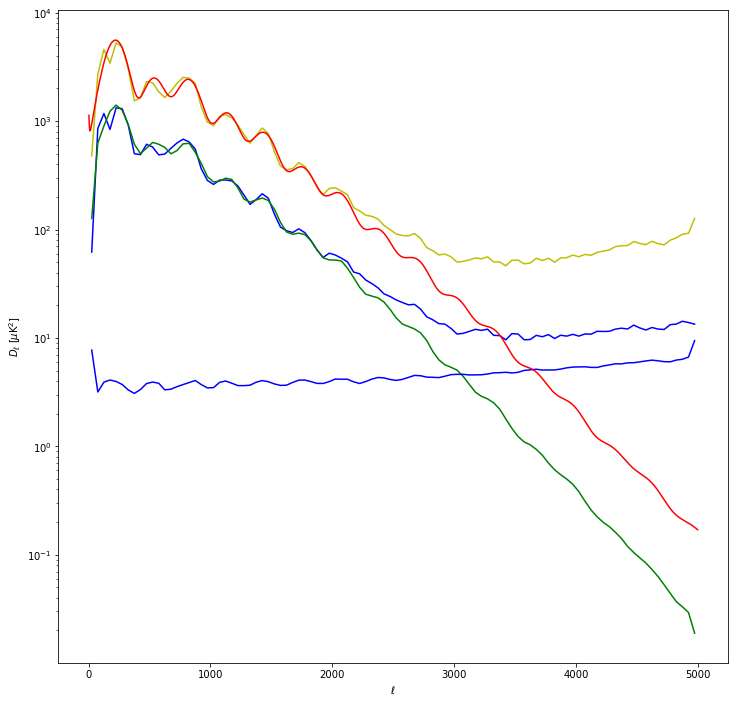

In [7]:
plt.figure(figsize=(12,12))

N_iteraciones = 32

solo_senal  = np.zeros([N_iteraciones,int(ell_max/delta_ell)])
i = 0

while (i <N_iteraciones):
    CMB_T = crear_mapa_CMB_T(N,tamaño_pix,ell,DlTT)
    CMB_T_convolucionado = mapa_convolucionado_con_haz_gaussiano(N,tamaño_pix,tamaño_haz_fwhm,CMB_T)
    binned_ell_cur, binned_spectrum_cur = calcular_espectro_2d(CMB_T_convolucionado*ventana,
                            CMB_T_convolucionado*ventana,delta_ell,ell_max,tamaño_pix,N)
    solo_senal[i,:] = binned_spectrum_cur
    sys.stdout.write("\r simulación solo señal, iteraciones completas: %d de %d" % ((i+1),N_iteraciones) )
    sys.stdout.flush()
    i = i + 1

def promedio_N_espectro(espectro,N_espectro,N_ells):
    promedioEspectro = np.zeros(N_ells)
    rmsEspectro = np.zeros(N_ells)
    
    # calcular el espectro promedio
    i = 0
    while (i < N_espectro):
        promedioEspectro = promedioEspectro + espectro[i,:]
        i = i + 1
    promedioEspectro = promedioEspectro/(1. * N_espectro)
    
    # calcula el rms del espectro
    i =0
    while (i < N_espectro):
        rmsEspectro = rmsEspectro +  (espectro[i,:] - promedioEspectro)**2
        i = i + 1
    rmsEspectro = np.sqrt(rmsEspectro/(1. * N_espectro))
    
    return(promedioEspectro,rmsEspectro)


espectro_promedio_solo_senal, rms_no_necesaria = promedio_N_espectro(solo_senal,N_iteraciones,int(ell_max/delta_ell))
    
sub_sampleado_CLs = DlTT[binned_ell] * 2. * np.pi / (binned_ell * (binned_ell+1.))

Sesgo_Multiplicativo_est =  sub_sampleado_CLs / espectro_promedio_solo_senal
   
## hacer algunos graficos
plt.clf()
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi,color='b')
plt.semilogy(binned_ell,(espectro_promedio_solo_senal)* binned_ell * (binned_ell+1.)/2. / np.pi,color='g')
plt.semilogy(binned_ell,(Sesgo_Multiplicativo_est),color='b')
plt.semilogy(binned_ell,(binned_spectrum)*Sesgo_Multiplicativo_est* binned_ell * (binned_ell+1.)/2. / np.pi,color='y')
plt.semilogy(ell,DlTT,color='r')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

Este gráfico muestra la estimación del espectro de potencia CMB después de corregir por el sesgo multiplicativo (función de transferencia) en amarillo. Además, mostramos en rojo el espectro de potencia CMB de entrada, en verde el promedio de las simulaciones de solo señal, azul-inferior la función de transferencia y azul-superior el espectro de potencia ingenuo de nuestro mapa. Considera cómo todas estas curvas se relacionan con la creación de la estimación amarilla. <font color='red'>EJERCICIO: </font>  ¿Por qué la curva verde se parece tanto a la curva roja pero suprimida? ¿Cuál es el significado de la curva suave azul-inferior?

Tus comentarios van aqui.

### Calibrando el sesgo de ruido

El sesgo de ruido se puede calcular ejecutando simulaciones de solo ruido a través del estimador de espectro de potencia ingenuo y calculando el espectro de potencia promedio.

NOTA: Existe un enfoque alternativo para tratar con el ruido. Si es que puedes subdividir tus datos en subconjuntos con señal común pero ruido independiente, se puede calcular el "espectro cruzado" entre estos subconjuntos. (Estos se calculan haciendo una transformada de Fourier 2d en cada subconjunto y luego multiplicando uno por el conjugado complejo del otro). Esto da como resultado cierta pérdida de información (ya que está descartando la autocorrelación de cada subconjunto, pero elimina por completo el potencial sesgo de medición de un modelo de ruido incorrecto.

Como ejercicio de dos partes: (1) use el modelo de ruido incorrecto al analizar el espectro de potencia para ver qué sucede, y (2) implemente un estimador de espectro cruzado para ver que este sesgo de ruido desaparece con los espectros cruzados. También tenga en cuenta que las barras de error crecen con el espectro cruzado.

 simulación solo ruido, iteraciones completas: 32 de 32

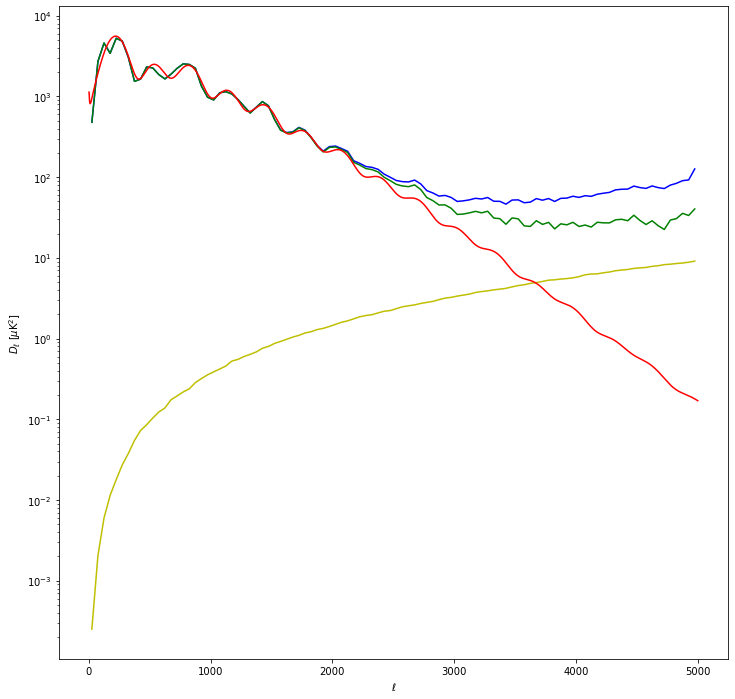

In [8]:
plt.figure(figsize=(12,12))

solo_ruido  = np.zeros([N_iteraciones,int(ell_max/delta_ell)])
i = 0
while (i <N_iteraciones):
    Ruido = hacer_mapa_de_ruido(N,tamaño_pix,nivel_de_ruido_blanco,nivel_de_ruido_atmosferico,nivel_de_ruido_1sobref)
    binned_ell_cur, binned_spectrum_cur = calcular_espectro_2d(Ruido*ventana,Ruido*ventana,delta_ell,ell_max,tamaño_pix,N)
    solo_ruido[i,:] = binned_spectrum_cur
    sys.stdout.write("\r simulación solo ruido, iteraciones completas: %d de %d" % ((i+1),N_iteraciones) )
    sys.stdout.flush()
    i = i + 1


espectro_promedio_solo_ruido, rms_no_necesaria = promedio_N_espectro(solo_ruido,N_iteraciones,int(ell_max/delta_ell))

Sesgo_Aditivo_est = espectro_promedio_solo_ruido

#plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi,color='b')
#plt.semilogy(binned_ell,(espectro_promedio_solo_senal)* binned_ell * (binned_ell+1.)/2. / np.pi,color='g')
plt.semilogy(binned_ell,(espectro_promedio_solo_ruido)* binned_ell * (binned_ell+1.)/2. / np.pi,color='y')
#plt.semilogy(binned_ell,(Multiplicative_Bias_est),color='b')
plt.semilogy(binned_ell,(binned_spectrum)*Sesgo_Multiplicativo_est*\
             binned_ell * (binned_ell+1.)/2. / np.pi,color='b')
plt.semilogy(binned_ell,(binned_spectrum - espectro_promedio_solo_ruido)\
             *Sesgo_Multiplicativo_est* binned_ell * (binned_ell+1.)/2. / np.pi,color='g')
plt.semilogy(ell,DlTT,color='r')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

La curva verde en este gráfico muestra nuestra estimación imparcial del espectro. Esta estimación incluye correcciones por el sesgo de ruido y la función de transferencia. La curva amarilla muestra nuestra estimación para el sesgo aditivo solo de ruido. La curva azul muestra el espectro teniendo en cuenta solo el sesgo multiplicativo como se hizo anteriormente. La curva roja muestra el espectro de potencia subyacente utilizado para generar nuestro mapa simulado.

En este punto tenemos una estimación imparcial del espectro de potencia (la curva verde). Ten en cuenta que a $\ell$-altos ($>3000$), el espectro está dominado por las componentes SZ y las fuentes puntuales. A continuación, debemos poner barras de error a estas medidas. Nuevamente hacemos esto usando el metodo Monte Carlo.

<font color='red'>EJERCICIO: </font>  ¿Qué es la curva amarilla? ¿Cómo se genera, cómo se utiliza para obtener la curva verde?

Tus comentarios van aquí

### Cuantificando las barras de error

Las barras de error se calculan generando simulaciones que incluyen señal y ruido, calculando el espectro de potencia ingenuo, tomando el RMS de estos resultados y luego restando el sesgo de ruido, teniendo en cuenta la función de transferencia. En efecto, estamos simulando ejecutar el experimento varias veces y observando el RMS de los resultados; este enfoque es ampliamente aplicable a otros problemas.

 simulación de señal más ruido, iteraciones completas: 32 de 32 

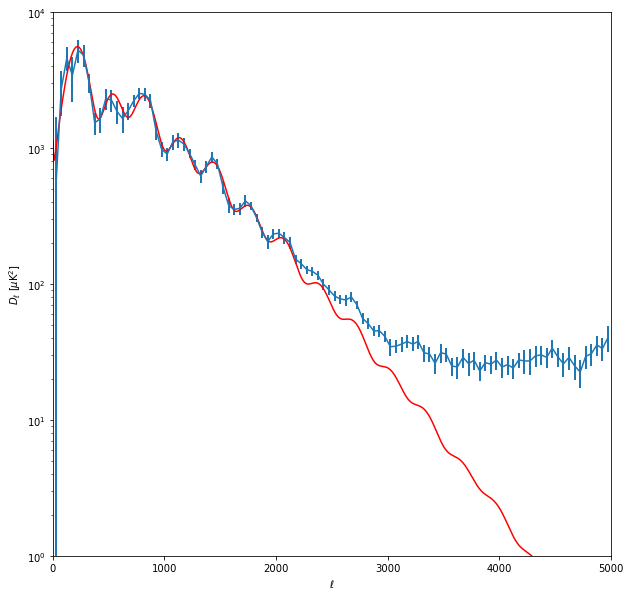

In [9]:
SmasR  = np.zeros([N_iteraciones,int(ell_max/delta_ell)])
i = 0
while (i <N_iteraciones):
    CMB_T = crear_mapa_CMB_T(N,tamaño_pix,ell,DlTT)

    MapaFP = componente_Poisson(N,tamaño_pix,Numero_de_Fuentes,Amplitud_de_Fuentes) 
    MapaFP += componente_Exponencial(N,tamaño_pix,Numero_de_Fuentes_EX,Amplitud_de_Fuentes_EX)
    MapaSZ,_ = componente_SZ(N,tamaño_pix,Numero_de_Cumulos_SZ,Amplitud_promedio_de_cumulos_SZ,
                                   SZ_beta,SZ_Theta_central,False)
    
    CMB_T  = CMB_T + MapaFP + MapaSZ

    CMB_T_convolucionado = mapa_convolucionado_con_haz_gaussiano(N,tamaño_pix,tamaño_haz_fwhm,CMB_T)
    Noise = hacer_mapa_de_ruido(N,tamaño_pix,nivel_de_ruido_blanco,nivel_de_ruido_atmosferico,nivel_de_ruido_1sobref)
    binned_ell_cur, binned_spectrum_cur = calcular_espectro_2d((CMB_T_convolucionado+Ruido)*ventana\
                                                                ,(CMB_T_convolucionado+Ruido)*ventana\
                                                                ,delta_ell,ell_max,tamaño_pix,N)
    SmasR[i,:] = binned_spectrum_cur
    sys.stdout.write("\r simulación de señal más ruido, iteraciones completas: %d de %d " % ((i+1),N_iteraciones) )
    sys.stdout.flush()
    #p=Plot_CMB_Map(CMB_T_convolucionado+Ruido,c_min,c_max,X_ancho,Y_ancho)
    i = i + 1
    
_,rms_senal_mas_ruido = promedio_N_espectro(SmasR,N_iteraciones,int(ell_max/delta_ell))


plt.clf()
plt.gcf().set_size_inches(10, 10)
plt.errorbar(binned_ell, (binned_spectrum - espectro_promedio_solo_ruido)*Sesgo_Multiplicativo_est* \
             binned_ell * (binned_ell+1.)/2. / np.pi, \
             yerr=rms_senal_mas_ruido*Sesgo_Multiplicativo_est* binned_ell * (binned_ell+1.)/2. / np.pi,\
             elinewidth=2)
plt.semilogy(ell,DlTT,color='r')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')

plt.xlim(0.,5000.)
plt.ylim(1.,10**4)

plt.show()




Ahí lo tenemos. Así es como calcula un espectro de potencia CMB con barras de error. Si quieres ajustar la cosmología a estos datos, puedes volver a ejecutar CAMB con parámetros cosmológicos variables y calcular la diferencia de probabilidad entre estos modelos y los datos. Esto se deja como ejercicio.

<font color='red'>EJERCICIO: </font>  ¿Por qué la curva roja (espectro CMB de entrada) no cae dentro de las barras de error de nuestro conjunto de datos simulados por encima de $\ell \sim 2500$?

Tus comentarios y discusión van aquí

<font color='red'>EJERCICIO: </font>  Uno podría preocuparse de que el cálculo de la función de transferencia dependa del espectro de entrada utilizado en el cálculo. Modifique el espectro utilizado para calcular la función de transferencia para que coincida mejor con el espectro en la simulación agregando una constante en cuadratura al espectro de entrada. Comenta sobre si esto cambia o no el resultado.

Tus comentarios van aquí